In [1]:
%load_ext pypath_magic
%pypath -a /home/vlad/projects/datamanagers/daily/

UsageError: '/home/vlad/projects/datamanagers/daily' is already in the user path.


In this notebook -- generalizations of OLS to Ridge, Lasso, feature selection etc, rather than working with hyp. testing for OLS (for this look and prob_stat_ols notebook)

In [21]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import sklearn.linear_model as lm

from daily.datamanager import DailyDataManager
import plotter.activate
from plotter import plot
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# data preparation

ddm = DailyDataManager()
df = ddm.get_data('fx_rates')
rets = df.pct_change()
rets = rets.loc[rets.isnull().sum(1) == 0]
rets = rets.fillna(0)

x = rets.drop('SEK', axis=1)
y = rets['SEK']

## Linear models

In [4]:
fit_res = sm.OLS(y, x).fit()

In [5]:
fit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    SEK   R-squared (uncentered):                   0.662
Model:                            OLS   Adj. R-squared (uncentered):              0.660
Method:                 Least Squares   F-statistic:                              425.6
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                        13:32:51   Log-Likelihood:                          6475.6
No. Observations:                1530   AIC:                                 -1.294e+04
Df Residuals:                    1523   BIC:                                 -1.290e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AUD            0.0772      0.020      3.801      0.000       0.037       0.117
CAD           -0.0057      0.025     -0.224      0.823      -0.055       0.044
CZK            0.1094      0.034      3.244      0.001       0.043       0.176
EUR            0.5032      0.039     12.766      0.000       0.426       0.580
GBP            0.0482      0.018      2.625      0.009       0.012       0.084
JPY           -0.0221      0.014     -1.613      0.107      -0.049       0.005
NOK            0.2490      0.017     14.541      0.000       0.215       0.283
==============================================================================
Omnibus:                       64.141   Durbin-Watson:                   2.252
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.280
Skew:                           0.173   Prob(JB):                     4.74e-37
Kurtosis:                       4.583   Cond. No.                         6.43
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
fit_res.params

AUD    0.077172
CAD   -0.005660
CZK    0.109381
EUR    0.503153
GBP    0.048219
JPY   -0.022111
NOK    0.248970
dtype: float64

In [10]:
fit_res.conf_int(0.99)

,0,1
AUD,0.076917,0.077426
CAD,-0.005976,-0.005343
CZK,0.108959,0.109804
EUR,0.502659,0.503647
GBP,0.047989,0.048449
JPY,-0.022283,-0.021939
NOK,0.248755,0.249185


In [22]:
# Unlike SM, sklearn version does not support pandas, has less fit stats, no summary, etc
fit_res_skl = lm.LinearRegression(fit_intercept=False).fit(x, y)
fit_res_skl.coef_

array([ 0.07717183, -0.00565955,  0.10938144,  0.50315262,  0.04821919,
       -0.02211102,  0.24897012])

## sklearn general feature selection tools

## Ridge

In [23]:
fit_res = lm.RidgeCV(cv=4).fit(x, y)
fit_res.coef_

array([0.07927641, 0.04680874, 0.14019994, 0.13689587, 0.08219256,
       0.02727289, 0.15612571])

In [19]:
fit_res.alpha_

0.1

## Lasso

In [24]:
fit_res = lm.LassoCV(cv=4).fit(x, y)
fit_res.coef_

array([ 0.07417489, -0.        ,  0.11045682,  0.49934052,  0.04741953,
       -0.01985022,  0.24811651])

### Lasso path

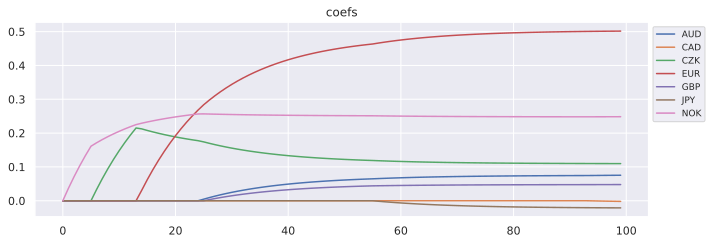

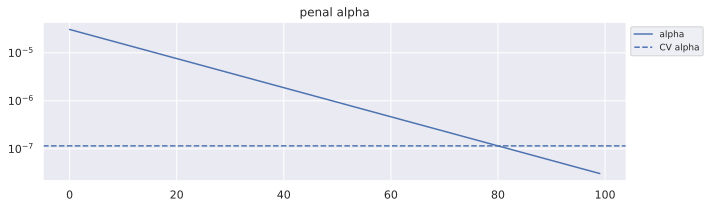

In [25]:
res_path = lm.lasso_path(x, y, eps=1e-3, fit_intercept=False)
res = lm.LassoCV(fit_intercept=False).fit(x, y)

with plot(7, wide=True, title='coefs') as p:
    pd.DataFrame(res_path[1].T, columns=x.columns).plot(ax=p.ax())
    
with plot(6, wide=True, title='penal alpha') as p:
    p.ax().semilogy(res_path[0], label='alpha')
    p.ax().axhline(res.alpha_, ls='--', label='CV alpha')

### Task: do forward stepwise feature selection with cross-validation of the number of features for various estimators (say OLS) -- purely using sklearn tools